<a href="https://colab.research.google.com/github/BradleyBrown19/DeepSimplexPivotFinder/blob/master/TSP2LP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
from itertools import permutations
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from scipy.optimize import linprog
import pickle
import os
from pathlib import Path

np.random.seed(420)

In [2]:
# TSP Solver (brute force)
def TSP(G, N):
    min_weight = float("inf")
    min_path = None

    for perm in permutations(list(range(1,N))):
      current_pathweight = G[0][perm[0]]
      for i in range(len(perm)-1):
          current_pathweight += G[perm[i]][perm[i+1]]
      current_pathweight += G[perm[-1]][0]
      # update
      if current_pathweight < min_weight:
        min_weight = current_pathweight
        min_path = perm

    return min_weight, [0] + list(min_path)

In [85]:
# UTIL GRAPH FUNCTIONS

# print adjacency matrix (distances rounded to 2 decimal)
def print_2d(M):
  for r in M:
    print([round(x,2) for x in r])
  print()

# generate N 2D points
# then convert all points to (v1, v2, w(v1, v2)) tuples to represent graph
def generate_euc_graph(N, D):
  def dist(a, b):
      return math.sqrt( (a[0]-b[0])**2 + (a[1]-b[1])**2 )
  # generate 2d points
  points = set()
  while len(points) < N:
    points.add((np.random.uniform(0,D), np.random.uniform(0,D)))
  points = np.array(list(points))
  # generate graph
  G = set()
  W = {}
  for i in range(N):
    for j in range(i+1, N):
      d = dist(points[i], points[j])
      G.add((i, j, d))
      W[i,j] = d
      W[j,i] = d
  return points, G, W

def generate_no_euc_graph(N, D):
    weights = np.clip(np.random.normal(D/2, D/4, int(N*(N-1)/2)), 
                      a_min=0, 
                      a_max=float("inf"))
    G = set()
    W = {}
    k = 0
    for i in range(N):
        for j in range(i+1, N): 
            G.add((i, j, weights[k]))
            W[i,j] = weights[k]
            W[j,i] = weights[k]
            k += 1
    assert k == N*(N-1)/2
    return G, W

# visualize 2D points
def visualize_points(points, D):
  plt.scatter([p[0] for p in points[1:]], 
              [p[1] for p in points[1:]], c="blue")
  plt.scatter(points[0][0], points[0][1], c='red')
  plt.ylim([0, D])
  plt.xlim([0, D])
  plt.show()

# convert graph represented in tuples to graph represented in
# adjacency matrix
def tuples2adj(G, N):
  M = [[0]*N for _ in range(N)]
  for u,v,w in G:
    M[u][v] = w
    M[v][u] = w
  return M

In [41]:
# UTIL SIMPLEX FUNCTIONS

def generate_constraints(N):
  # A_eq
  A_eq = [[0]*((N+1)*(N-1)) for _ in range(2*N)]
  k = 0
  for i in range(N):
    for j in range(N):
      if i != j:
        A_eq[i][k] = 1
        A_eq[j+N][k] = 1
        k += 1
  # A_ub
  A_ub = [[0]*((N+1)*(N-1)) for _ in range((N-1)*(N-2))]
  k = 0
  q = 0
  for i in range(N):
    for j in range(N):
      if i == j:
        continue
      if i == 0 or j == 0:
        k += 1
        continue
      A_ub[q][k] = N
      A_ub[q][(N*(N-1))+i-1] = 1
      A_ub[q][(N*(N-1))+j-1] = -1
      k += 1
      q += 1
  # b_eq
  b_eq = [1]*(2*N)
  # b_ub
  b_ub = [N-1]*((N-1)*(N-2))

  # combine A_eq to A_ub and b_eq to b_ub as our 
  # simplex solver does not support equality
  for r, b in zip(A_eq, b_eq):
    A_ub.append(r)
    A_ub.append([-x for x in r])
    b_ub.append(b)
    b_ub.append(-b)

  assert len(A_ub) == N**2+N+2
  assert len(A_ub) == len(b_ub)

  return A_ub, b_ub


def generate_c(W):
  # c
  c = []
  for i in range(N):
    for j in range(N):
      if i != j:
        c.append(W[i,j])
  c += [0]*(N-1)
  return c


# branch-and-bound using simplex solver
def branch_and_bound_simplex(A_eq, A_ub, b_eq, b_ub, c, N):
  soln = float("inf")
  best_x = None

  stack = [(A_eq, b_eq)]
  while stack:
    A_eq, b_eq = stack.pop()
    res = linprog(c=c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, method="simplex")
    x = res["x"]
    fun = res["fun"]
    status = res["status"]
    if status != 0:
      continue

    # check which Xij is not 0 or 1
    i = 0
    while i < N*(N-1):
      if abs(x[i]) > 0.001 and abs(x[i]-1) > 0.001:
        break
      i += 1

    if i == N*(N-1) and fun < soln:
      soln = fun
      best_x = x
    elif fun < soln:
      r = [0]*((N+1)*(N-1))
      r[i] = 1
      stack.append((A_eq+[r], b_eq+[1]))
      stack.append((A_eq+[r], b_eq+[0]))

  return soln, best_x

In [34]:
# DEFINE PARAMS
N = 5 # number of nodes in TSP
D = 10 # all 2D points lie within x=(0,D) and y=(0,D)

Generated Locations:


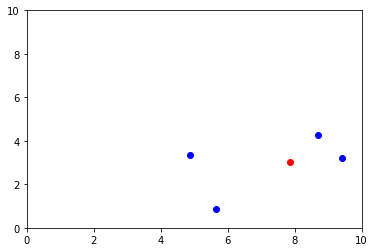


Adjacency Matrix:
[0, 1.56, 3.09, 3.0, 1.52]
[1.56, 0, 4.44, 4.54, 1.29]
[3.09, 4.44, 0, 2.6, 4.58]
[3.0, 4.54, 2.6, 0, 3.92]
[1.52, 1.29, 4.58, 3.92, 0]

path: [0, 1, 4, 3, 2, 0]
distance: 12.460639778254624


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


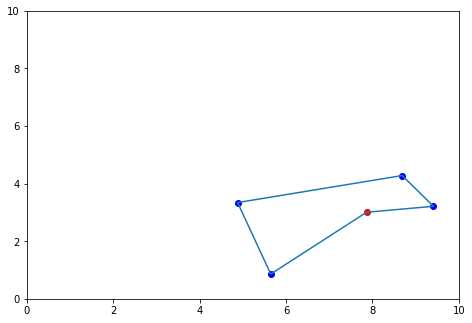

In [35]:
# STEP 2: GENERATE GRAPH
points, G, W = generate_euc_graph(N, D)
print("Generated Locations:")
visualize_points(points, D)
M = tuples2adj(G, N)
print("\nAdjacency Matrix:")
print_2d(M)

# STEP 3: SOLVE TSP
dist, path = TSP(M, N)
path.append(path[0])
ordered_point = points[path]
print("path: " + str(path))
print("distance: " + str(dist))

# STEP 4: VISUALIZE
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1, 1])
axes.set_xlim(0, D)
axes.set_ylim(0, D)
# points
axes.plot(points[0][0], points[0][1], marker='o', c='red')
for i in range(1,N):
  axes.plot(points[i][0], points[i][1], marker='o', c="blue")
# draw used edges
axes.plot(ordered_point[:,0], ordered_point[:,1])
fig.show()

In [92]:
# make a bunch of dirs
Path("data").mkdir(parents=True, exist_ok=True)
Path("data/4_euclid").mkdir(parents=True, exist_ok=True)
Path("data/4_no_euclid").mkdir(parents=True, exist_ok=True)
Path("data/6_euclid").mkdir(parents=True, exist_ok=True)
Path("data/6_no_euclid").mkdir(parents=True, exist_ok=True)
Path("data/8_euclid").mkdir(parents=True, exist_ok=True)
Path("data/8_no_euclid").mkdir(parents=True, exist_ok=True)
Path("data/10_euclid").mkdir(parents=True, exist_ok=True)
Path("data/10_no_euclid").mkdir(parents=True, exist_ok=True)

In [93]:
# CONFIGS
NUM_DATA = 5000 # number of TSPs

def generateData(N, NUM_DATA, euclidean=True):
  A, b = generate_constraints(N)
  for i in range(1,NUM_DATA+1):
    # GENERATE GRAPH
    if euclidean:
        _, G, W = generate_euc_graph(N, D)
    else:
        G, W = generate_no_euc_graph(N, D)
    c = generate_c(W)
    
    euc = "euclid" if euclidean else "no_euclid"
    with open(f'data/{N}_{euc}/{i}.pickle', 'wb') as f:
      pickle.dump({"c":c, "A":A, "b":b, "prob": "min"}, f)

    # quick sanity test below
    # dist, _ = TSP(M, N)
    # res = linprog(c=c, A_ub=A, b_ub=b, method="simplex")
    # print(res)
    # assert res['status'] == 0
    # assert dist >= res["fun"] or abs(dist - res["fun"]) < 1e-3, print(dist, res["fun"])

for N in [4,6,8,10]:
    for euc in [True, False]:
        generateData(N, NUM_DATA, euc)

(array([ 53366., 133567., 178869., 192473., 177778., 141758.,  86888.,
         28567.,   6186.,    548.]),
 array([1.00376084e-03, 1.38585212e+00, 2.77070047e+00, 4.15554883e+00,
        5.54039719e+00, 6.92524554e+00, 8.31009390e+00, 9.69494226e+00,
        1.10797906e+01, 1.24646390e+01, 1.38494873e+01]),
 <a list of 10 Patch objects>)

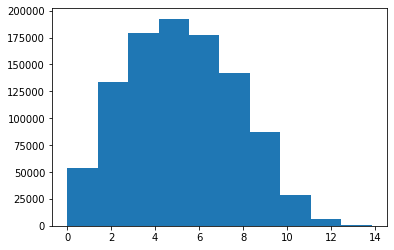

In [29]:
# scribble to get a sense of distribution of distances in euclidean
def dist(a, b):
    return math.sqrt( (a[0]-b[0])**2 + (a[1]-b[1])**2 )

dists = []
for _ in range(int(1e6)):
    d = dist((np.random.uniform(0,D), np.random.uniform(0,D)),
             (np.random.uniform(0,D), np.random.uniform(0,D)))
    dists.append(d)
plt.hist(dists)

In [ ]:
# another scratch test (5-10 mins to run)
# data_dir = Path("data")
# for N in [4,6,8,10]:
#     for euc in ["euclid", "no_euclid"]:
#         k = 0
#         for f in (data_dir / f"{N}_{euc}").glob("*"):
#             with open(f, "rb") as file:
#                 data = pickle.load(file)
#             A = data["A"]
#             b = data["b"]
#             c = data["c"]
#             prob = data["prob"]
            
#             res = linprog(c=c, A_ub=A, b_ub=b, method="simplex")
#             assert res['status'] == 0
#             assert res['fun'] > 0
#             print(res["fun"])
#             k += 1
#             if (k >= 100):
#                 break
#         print(f"done {N}_{euc}")